In [21]:
# Python imports
import os

# PyTorch imports
import torch
import torchvision

# Third-party imports
import matplotlib.pyplot as plt
from tabulate import tabulate

# Own imports
import utils

# 0. Constants

In [22]:
# Hyper-parameters.
LEARNING_RATE = 0.01
EPOCHS = 30
BATCH_SIZE = 100

# Others.
WIDTH, HEIGHT = 28, 28
SAVED_FILENAME = 'MNIST-MLP-0'

# 1. Dataset

I use MNIST as the dataset.

* Image width is 28.
* Image height is 28.
* Image channel is 1.
* Value of each pixel is in [0, 1].

Load training and test datasets.

In [23]:
# image, label = dataset_training[i]
# image, label = dataset_training[i]
# image is a tensor of shape (1, WIDTH, HEIGHT).
# label is a Python int number.
dataset_training = torchvision.datasets.MNIST('./data', download=True, train=True, transform=torchvision.transforms.ToTensor())
dataset_test = torchvision.datasets.MNIST('./data', download=True, train=False, transform=torchvision.transforms.ToTensor())

Create data loaders for training and test.

In [24]:
# samples = next(iter(dataloader_training))
# samples = next(iter(dataloader_test))
# samples is a Python list of len 2.
# samples[0] is a tensor of shape (BATCH_SIZE, 1, WIDTH, HEIGHT)
# samples[1] is a tensor of shape (BATCH_SIZE,)
dataloader_training = torch.utils.data.DataLoader(dataset_training, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

Inspect number of samples in both datasets.

In [25]:
headers = ['Dataset', 'Number of Samples']
rows = [
    ['Training', len(dataset_training)],
    ['Test', len(dataset_test)],
]

# Print the table.
print(tabulate(rows, headers=headers, tablefmt='github'))

| Dataset   |   Number of Samples |
|-----------|---------------------|
| Training  |               60000 |
| Test      |               10000 |


Sample images of all labels.

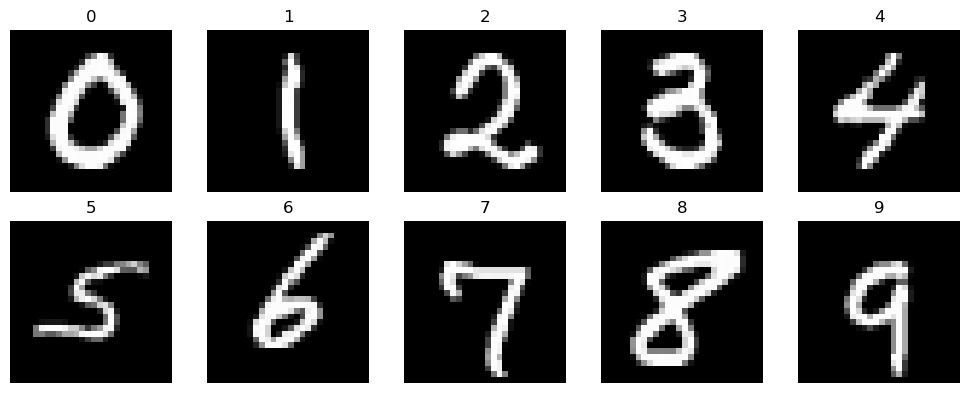

In [26]:
# Sample 10 images with labels 0 to 9.
samples = utils.sample_MNIST_with_all_labels(dataset_training)

# Plot the images.
rows, cols = 2, 5
fig, axs = plt.subplots(rows, cols, figsize=(10, 4))
for row in range(rows):
    for col in range(cols):
        axs[row, col].imshow(samples[row*cols+col].squeeze(), cmap=plt.cm.gray)
        axs[row, col].axis('off')
        axs[row, col].set_title(row*cols+col)
plt.tight_layout()